# Project


## Data Fetching from Data Base


In [1]:
h:0N!hopen `$":tpr-mscf-kx.tepper.cmu.edu:5000:mscf2019:mmat46982"

1000i


In [2]:
tab2df:{r:.p.import[`pandas;`:DataFrame.from_dict;flip 0!x][@;cols x];$[count k:keys x;r[`:set_index]k;r]}

In [3]:
syms:`MMM`AXP`AAPL`BA`CAT`CVX`CSCO`KO`DIS`DWDP
/syms,:`XOM`GS`HD`IBM`INTC`JNJ`JPM`MCD`MRK`MSFT
/syms,:`NKE`PFE`PG`TRV`UTX`UNH`VZ`V`WMT`WBA

In [4]:
nbboquery:{[sd;ed;st;et;s]
 t:select from nbbo where date within (sd,ed), sym in s,time within (st,et);
 t}

In [5]:
landrquerysummary:{[st;et;s;c;w;sd;ed]
    / YOUR CODE HERE
 t:select date,time,sym,price,size from trade where date within(sd,ed),sym in s,time within (st,et),cond in c;
 t: aj[`sym`time;t] select time,`p#sym,bsize,bid,ask,asize from nbbo where date within(sd;ed),sym in s,time within(st,et);
 t: select vwap:"e"$size wavg price, avg bid, avg ask, sum bsize, sum asize,sum size by date,w xbar time,sym from t;
 t: select date+time,sym,bid,ask,mid:(bid+ask)%2,bsize,asize,size from t;
 /t: select date+second,sym,mid:(bid+ask)%2 from t;

/t:select time,`p#sym,bsize,bid,ask,asize from nbbo where date within (sd,ed),sym in s,time within(st,et);
 /t: select avg bid, avg ask, sum bsize, sum asize,sum size by date,time.minute,sym from t;

 t}

In [6]:
show t:h (landrquerysummary;09:30;16:00;syms;" ";0D00:00:30;2018.09.04;2018.09.04)

date                          sym  bid      ask      mid      bsize asize siz..
-----------------------------------------------------------------------------..
2018.09.04D09:30:00.000000000 AAPL 228.1125 228.1527 228.1326 5747  2645  150..
2018.09.04D09:30:00.000000000 AXP  106.1055 106.19   106.1478 293   270   201..
2018.09.04D09:30:00.000000000 BA   341.6    341.98   341.79   1     1     100..
2018.09.04D09:30:00.000000000 CAT  138.2652 138.5685 138.4168 136   447   180..
2018.09.04D09:30:00.000000000 CSCO 47.8453  47.86215 47.85373 7355  3573  113..
2018.09.04D09:30:00.000000000 CVX  118.7841 118.8981 118.8411 171   244   116..
2018.09.04D09:30:00.000000000 DIS  111.74   111.9036 111.8218 48    79    277..
2018.09.04D09:30:00.000000000 DWDP 69.87316 69.93228 69.90272 425   795   179..
2018.09.04D09:30:00.000000000 KO   44.5713  44.5853  44.5783  2860  1339  441..
2018.09.04D09:30:00.000000000 MMM  210.52   211.216  210.868  5     23    500..
2018.09.04D09:30:30.000000000 AAPL 228.1

## Data Processing

In [7]:
/%python
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression

sns.set(rc={'figure.figsize':(11.7,8.27)})


In [8]:
.p.set[`df] tab2df t

In [9]:
/%python
df.date =  pd.to_datetime(df.date,origin='2000.01.01')
df=df.set_index("date")
print(df)

                      sym         bid         ask   ...    bsize   asize    size
date                                                ...                         
2018-09-04 09:30:00  AAPL  228.112504  228.152749   ...     5747    2645  150277
2018-09-04 09:30:00   AXP  106.105533  106.190000   ...      293     270   20106
2018-09-04 09:30:00    BA  341.600006  341.980011   ...        1       1     100
2018-09-04 09:30:00   CAT  138.265169  138.568501   ...      136     447   18078
2018-09-04 09:30:00  CSCO   47.845304   47.862153   ...     7355    3573  113071
2018-09-04 09:30:00   CVX  118.784127  118.898094   ...      171     244   11628
2018-09-04 09:30:00   DIS  111.740000  111.903570   ...       48      79    2770
2018-09-04 09:30:00  DWDP   69.873163   69.932279   ...      425     795   17916
2018-09-04 09:30:00    KO   44.571301   44.585300   ...     2860    1339   44152
2018-09-04 09:30:00   MMM  210.520001  211.216003   ...        5      23     500
2018-09-04 09:30:30  AAPL  2

We now have 30-second bid ask data for 10 stocks. Create dataframe all_mid_price for the 10 stocks and create base strategy. Note that mid price data has NAs in it, here i just used ffill to fill in the last valid mid price, and saved to csv

In [10]:
/%python
all_symbol=df["sym"].unique()
all_mid_price=pd.DataFrame([])
for s in all_symbol:
    all_mid_price[s]=df[df["sym"]==s]["mid"]
all_mid_price.fillna(method="ffill",inplace = True)
all_mid_price.to_csv("mid_price.csv")
print(all_mid_price.head())

                           AAPL         AXP     ...             KO         MMM
date                                            ...                           
2018-09-04 09:30:00  228.132627  106.147767     ...      44.578301  210.868002
2018-09-04 09:30:30  228.190561  106.234375     ...      44.565594  210.440002
2018-09-04 09:31:00  228.555690  106.226999     ...      44.545926  210.305000
2018-09-04 09:31:30  228.721917  106.233500     ...      44.541667  209.980519
2018-09-04 09:32:00  228.787086  106.091999     ...      44.521532  209.765501

[5 rows x 10 columns]


## Pair Selection 

### price correlation

First calculate correlation between prices, and pick the top 5% highest correlation

In [11]:
/%python
corr_matrix_p = all_mid_price.corr(method='pearson').abs()
corr_pairs_p = (corr_matrix_p.where(np.triu(np.ones(corr_matrix_p.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
corr_pairs_p=pd.DataFrame(corr_pairs_p)
corr_pairs_p.columns=['correlation']


print(corr_pairs_p.head())

           correlation
CSCO DWDP     0.848124
AXP  BA       0.830094
DWDP MMM      0.805301
CSCO MMM      0.763329
BA   DIS      0.619609


In [12]:
/%python 
correlation_threshold=95
selected_pairs_corr_p=corr_pairs_p[corr_pairs_p>np.percentile(corr_pairs_p,correlation_threshold)].dropna()
print(selected_pairs_corr_p)

           correlation
CSCO DWDP     0.848124
AXP  BA       0.830094
DWDP MMM      0.805301


## Cointegration tests
The lower the p-value, the more significant will the stationary results.
We pick pairs that are highly cointegrated. Note that high price correlation doesn't mean they are cointegrated. e.g the AXP BA pair

In [13]:
/%python
all_pvalue=pd.Series(index=selected_pairs_corr_p.index)
for i in range(len(selected_pairs_corr_p)):
    first=selected_pairs_corr_p.index[i][0]
    second=selected_pairs_corr_p.index[i][1]
    _, p_value, _ = coint(all_mid_price[first], all_mid_price[second])
    all_pvalue[(first,second)]=p_value
selected_pairs_corr_p['pvalue']=all_pvalue
selected_pairs_corr_p=selected_pairs_corr_p.sort_values(by='pvalue', ascending=True)

print(selected_pairs_corr_p)

           correlation    pvalue
DWDP MMM      0.805301  0.000202
CSCO DWDP     0.848124  0.002815
AXP  BA       0.830094  0.251041


## Visualizing the spread
This Function serves to plot the movement of price within a time interval
It also will plot the ratio of price of two securities to check if they are stationary.

In [14]:
/%python

def plot_spread(df, tick1, tick2, index, op, stop):
  
    px1 = df[tick1].iloc[index]/df[tick1].iloc[index[0]]
    px2 = df[tick2].iloc[index]/df[tick2].iloc[index[0]]
    
    px1=np.log(px1)
    px2=np.log(px2)
    
    sns.set(style='white')
    
    # Set plotting figure
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})

    # Plot the return plot
    sns.lineplot(data=[px1, px2], linewidth=1.2, ax=ax[0])
    ax[0].legend(loc='upper left')
    
    # Calculate the spread and other thresholds
    spread = df[tick1].iloc[index] - df[tick2].iloc[index]
    #spread = px1 - px2

    mean = spread.mean()
    sell_th     = mean + op
    sell_stop   = mean + stop
    buy_th      = mean - op
    buy_stop    = mean - stop
    
    # Plot the 2nd subplot
    sns.lineplot(data=spread, color='#85929E', ax=ax[1], linewidth=1.2)
    ax[1].axhline(sell_th,   color='b', ls='--',  label='sell_threshold',linewidth=2)
    ax[1].axhline(buy_th,    color='r', ls='--', label='buy_threshold',linewidth=2)
    ax[1].axhline(sell_stop, color='g', ls='--',  label='sell_stop',linewidth=1)
    ax[1].axhline(buy_stop,  color='y', ls='--',  label='buy_stop',linewidth=1)
    ax[1].fill_between(idx, sell_th, buy_th, facecolors='r',alpha=0.4)
    ax[1].legend(loc='upper left', labels=['Spread', 'sell_th', 'buy_th', 'sell_stop', 'buy_stop'], prop={'size':8.5})
    plt.show()

We can see that the MMM DWDP and CSCO DWDP spread looks good -high correlation and cointegrated while the AXP and BA pair looks bad - high correlation but not cointegrated. 
So far our pair selection process seems to be of value

One thing to notice is that DWDP ticker is delisted, might be an issue going further. sb please figure this out in data base.

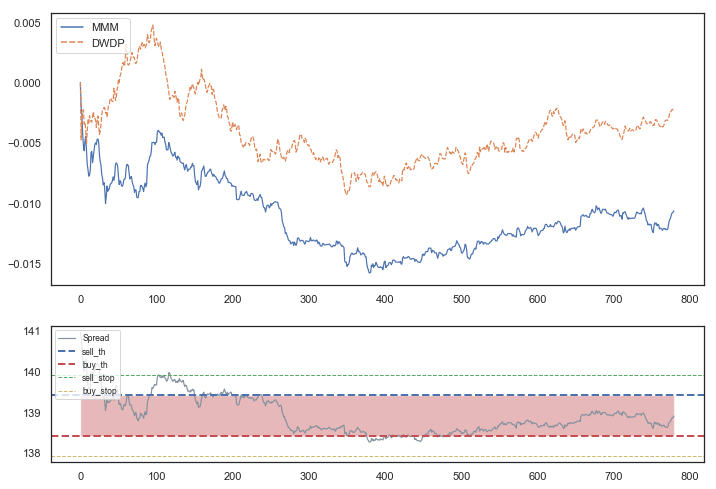

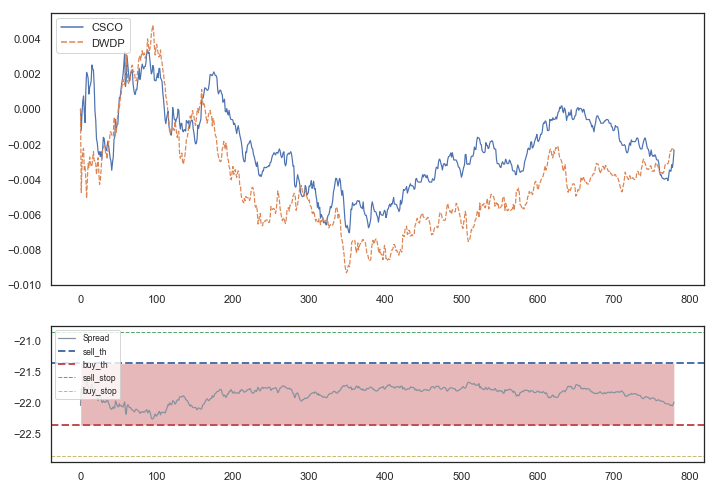

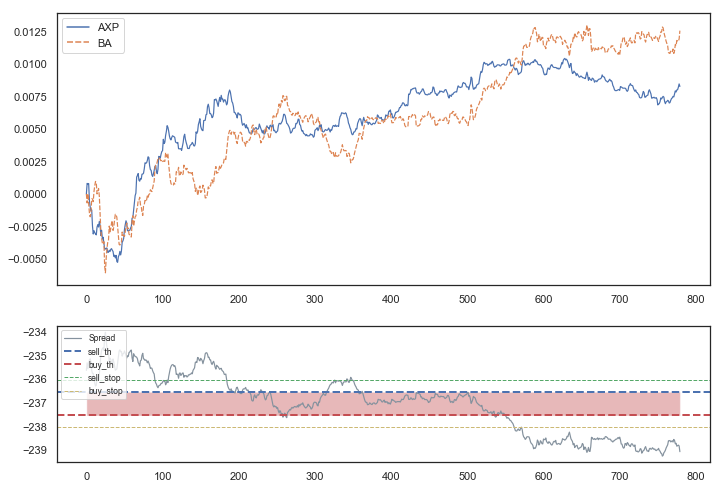

In [15]:
/%python
one="MMM"
two="DWDP"
idx = range(len(all_mid_price))
temp=all_mid_price.copy()
temp=temp.reset_index(drop=True)
plot_spread(temp, one, two, idx, .5, 1)

one="CSCO"
two="DWDP"
idx = range(len(all_mid_price))
temp=all_mid_price.copy()
temp=temp.reset_index(drop=True)
plot_spread(temp, one, two, idx, .5, 1)

one="AXP"
two="BA"
idx = range(len(all_mid_price))
temp=all_mid_price.copy()
temp=temp.reset_index(drop=True)
plot_spread(temp, one, two, idx, .5, 1)

## Base Algorithm

### Algo Intuition :
Suppose Y denotes for security one, X denotes for security two. 

We have: $Y=\alpha+\beta*X+\epsilon$

If the estimated next Y value is above our estimate, we believe Y is overpriced. We can short Y and long X with beta amount. We want to long X in this case is because while Y is over-priced relative to X. Thus, we can gain both side of trade by doing long-short in statistical arbitrage. 

### Algo Assumptions:
1.	There are relatively small changes in price in each second.
2.	If price tick is not given, I assume there is not price change. Therefore, I will use the last tick price.

### Base Trading Algo:
1. Start with position 0 for X and Y
2. Perform rolling base linear regression. Use the residual $\epsilon$ as trading signal. openBound, closeBound, and stopBound are thresholds at which our signal triggers a trade. Currently openBound = 2, closeBound = 1, stopBound = 3. i.e. we enter a long posistion if the residual is 2 standard deviations above 0.
3. Long spread positions mean long X and short Y. When signal enters open and stop, we long one beta-neutral spread: long $\beta$ shares of X and short 1 share of Y
4. Having a long spread position on, we close the position when signal reaches stopBound is reached (stop loss), or when closeBound is reached (collect profit)
5. Having a long spread position on, if neither closing coditions are met, we adjust our position to remain $\beta$ neutral for all time indices. 
6. Trade short spread positions the other way around.

This Function updates position given the last xPosition and yPosition as well as regression results. 

In [16]:
/%python
def update_position(xLastPosition,yLastPosition,signal,openBound,closeBound,stopBound,positionVolume):
    xNewPosition, yNewPosition = xLastPosition,yLastPosition
    # Long spread x-y
    if (yLastPosition>=0 and signal>=openBound and signal<=stopBound):
        xNewPosition, yNewPosition = positionVolume, -1

    # Short spread 
    elif(yLastPosition<=0 and signal<=-openBound and signal>=-stopBound):
        xNewPosition, yNewPosition = -positionVolume, 1
    
    # Close long spread
    elif(yLastPosition>0 and (signal<-stopBound or signal>-closeBound)):
        xNewPosition, yNewPosition = 0, 0
    
    # Close short spread
    elif(yLastPosition<0 and (signal>stopBound or signal<closeBound)):
        xNewPosition, yNewPosition = 0, 0
    
    # Adjust long spread
    elif(yLastPosition<0 and ~(signal>stopBound or signal<closeBound)):
        xNewPosition, yNewPosition = positionVolume, -1
    
    # Adjust short spread
    elif(yLastPosition>0 and ~(signal<-stopBound or signal>-closeBound)):
        xNewPosition, yNewPosition = -positionVolume, 1
        
    return xNewPosition,yNewPosition

Back_test function for the base algo: creates a plot of returns over time and outputs trading log for debugging

In [17]:
/%python
def back_test(all_price_data,tick1,tick2,debug=False):
    price_1=all_price_data[tick1][0]
    price_2=all_price_data[tick2][0]
    if(price_1>=price_2):
        backtest_data=all_price_data[[tick1,tick2]].copy()
    else:
        backtest_data=all_price_data[[tick2,tick1]].copy()
    backtest_data=pd.DataFrame(backtest_data)
    backtest_data.columns=['price_y','price_x']
    backtest_data['ln_x']=np.log(backtest_data['price_x'])
    backtest_data['ln_y']=np.log(backtest_data['price_y'])
    
    # model paramters hardcoded, RECODE THIS
    lookback=100
    n=lookback 
    open_const=2
    stop_const=3
    close_const=1
    
    fee=0
    backtest_data['residual']=0
    backtest_data['std']=0
    backtest_data['position_x']=0
    backtest_data['position_y']=0
    backtest_data['profit_x']=0
    backtest_data['profit_y']=0
    backtest_data['coef']=0

    for i in range(n+1,len(backtest_data)):
        
        # Rolling Linear Regression to get signal
        X=np.array(backtest_data['ln_x'][i-n:i-1]).reshape(-1,1)
        Y=np.array(backtest_data['ln_y'][i-n:i-1])
        model=LinearRegression().fit(X,Y)
        coef=model.coef_[0]        
        residual=Y-model.predict(X)
        std=np.std(residual)
        next_X=np.array(backtest_data['ln_x'][i]).reshape(-1,1)
        next_Y=np.array(backtest_data['ln_y'][i])
        Y_hat=model.predict(next_X)
        next_residual=next_Y-Y_hat
        backtest_data['residual'].iloc[i]=next_residual
        backtest_data['std'].iloc[i]=std
        
        # Use regression residual as signal to trade
        xNewPosition,yNewPosition = update_position(xLastPosition = backtest_data['position_x'].iloc[i-1],
                                                    yLastPosition = backtest_data['position_y'].iloc[i-1],
                                                    signal = backtest_data['residual'].iloc[i],
                                                    openBound = open_const*backtest_data['std'].iloc[i],
                                                    closeBound = close_const*backtest_data['std'].iloc[i],
                                                    stopBound = stop_const*backtest_data['std'].iloc[i],
                                                    positionVolume = abs(coef))
        
        backtest_data['position_x'].iloc[i], backtest_data['position_y'].iloc[i] = xNewPosition,yNewPosition

        backtest_data['profit_x'].iloc[i]=backtest_data['position_x'].iloc[i-1]*(backtest_data['price_x'].iloc[i]/backtest_data['price_x'].iloc[i-1]-1)-abs(backtest_data['position_x'].iloc[i-1]-backtest_data['position_x'].iloc[i-2])*fee  #profit_x
        backtest_data['profit_y'].iloc[i]=backtest_data['position_y'].iloc[i-1]*(backtest_data['price_y'].iloc[i]/backtest_data['price_y'].iloc[i-1]-1)-abs(backtest_data['position_y'].iloc[i-1]-backtest_data['position_y'].iloc[i-2])*fee  #profit_x
    
    #print trading log for debugging 
    if (debug):
        backtest_data.to_csv("backtest_trading_log.csv")
    
    #calculate profit
    backtest_data['total_profit']=backtest_data['profit_x']+backtest_data['profit_y']
    backtest_data['cum_profit']=np.cumsum(backtest_data['total_profit'])
    
    result=pd.DataFrame([backtest_data['cum_profit'][-1]], columns=['return'])
    result['open']=open_const
    result['close']=close_const
    result['stop']=stop_const
    result['lookback']=n
    result['tick_1']=tick1
    result['tick_2']=tick2
    
    plt.plot(backtest_data['cum_profit'].reset_index(drop=True))
    plt.title('Cumulative Return vs Time')
    plt.show()
    return result

### Somebody fix this warning code is too slow for tuning model.

Our base strategy is good. Refer to the trading log file to debug/play around. DWDP MMM and DWDP CSCO, the highly cointegrated pairs made money and AXP BA, the pair with high price correlation but not cointegrated is losing. 

C:\Users\kevin\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


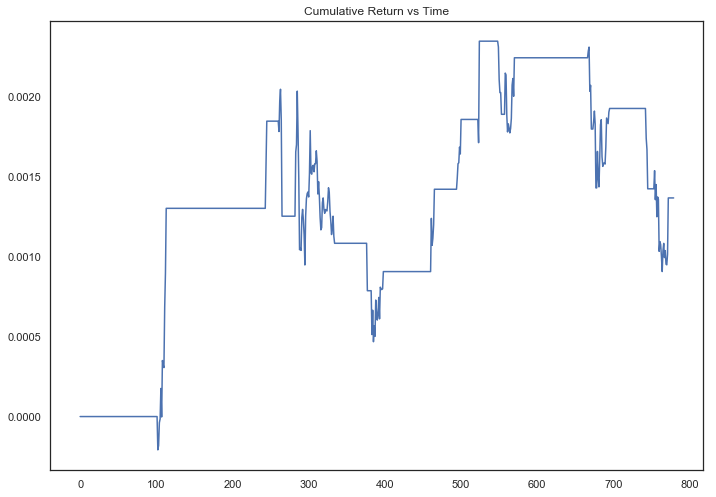

In [18]:
/%python
back_test(all_mid_price,"DWDP","MMM")

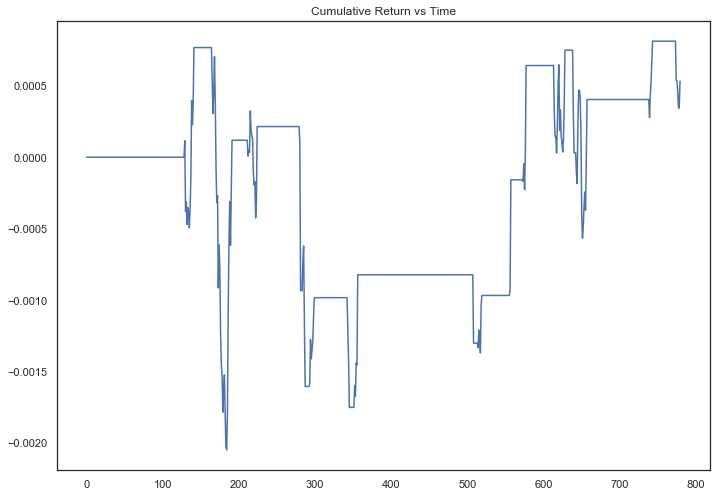

In [19]:
/%python
back_test(all_mid_price,"DWDP","CSCO")

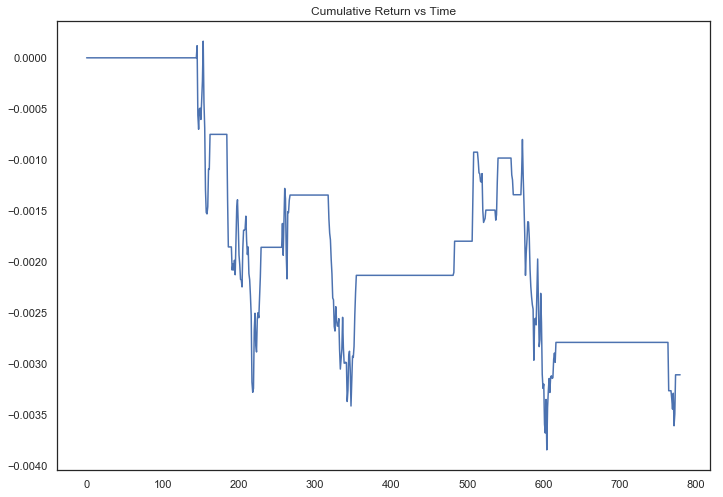

In [20]:
/%python
back_test(all_mid_price,"AXP","BA")

## TODO

Refer to Readme.

Refer to yjy_code_deprecated. yjy did grid search for model tuning, and some stuff on volume issues and trading capacity limits etc. It was for futures sadly, not really applicable to this project. 

Priority is the algo, not pair selection. The pair selection process is already great.